In [1]:
# !pip install seaborn
# !pip install pandarallel
# !pip install ipywidgets

In [2]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from rdkit import RDLogger
import matplotlib.pyplot as plt
import seaborn as sns

from smiles_utils import filter_and_canonicalize, AllowedSmilesCharDictionary, split_charged_mol

smiles_char_dict = AllowedSmilesCharDictionary()

def clean_smile(smiles):
    # only keep reasonably sized molecules
    if 5 > len(smiles) or len(smiles) > 200:
        return None
    
    smiles = split_charged_mol(smiles)

    if not smiles_char_dict.allowed(smiles):
        return None
    
    filtered_smiles = filter_and_canonicalize(smiles)
    return filtered_smiles[0] if filtered_smiles else None

CURRENT_DIR = Path('.').resolve()
os.chdir(CURRENT_DIR / "../chemprop")

import chemprop

# Suppress warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import torch
torch.cuda.is_available()

True

In [3]:
MODELS_DIR = CURRENT_DIR / ".." / "models_chemprop"
ASSAYS_DIR = CURRENT_DIR / ".." / "data" / "Assays-pXC50"

pal=list(sns.color_palette("tab10"))

In [4]:
from sklearn.ensemble import RandomForestRegressor

def train_rf(target):
    train_data = pd.read_csv(ASSAYS_DIR / f"{target}.csv")
    X = train_data['smiles'].apply(clean_smile)
    train_data = train_data[X.notnull()]

    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(train_data, target)
    return rf

In [15]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

# load qsar models for each target
targets = ['AChE', 'D2R', 'D3R', '_5HT2A', 'MAOB']
predicted_activities = dict()
active_molecules = dict()

filtered_smiles = dict()

for target in targets:
    # load active molecules dataset for each target
    X = pd.read_csv(ASSAYS_DIR / f'{target}.csv')
    X['SMILES'] = X['SMILES'].parallel_apply(clean_smile)
    X = X.dropna().sample(1500)

    filtered_smiles[target] = X

for target_model in targets:
    print(f'Loading {target_model} model')
    predicted_activities[target_model] = dict()
    arguments = [
        '--test_path', '/dev/null',
        '--preds_path', '/dev/null',
        '--checkpoint_dir', str(MODELS_DIR / f'{target_model}-pXC50-checkpoint'),
        # '--gpu', '0',
    ]

    for target_dataset in targets:
        print(f'Predicting activity for {target_dataset} dataset')

        X = filtered_smiles[target_dataset]
        smiles = X['SMILES'].to_list()
        smiles_input = [[s] for s in smiles]

        args = chemprop.args.PredictArgs().parse_args(arguments)
        preds = chemprop.train.make_predictions(args=args, smiles=smiles_input)

        predicted_activities[target_model][target_dataset] = np.array(preds).flatten()

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/arthurcerveira/cMolGPT-Brain-Diseases/chemprop/chemprop/utils.py:472: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vars(torch.load(path, map_location=lambda storage, 

Loading AChE model
Predicting activity for AChE dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]/home/arthurcerveira/cMolGPT-Brain-Diseases/chemprop/chemprop/utils.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D2R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.81s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D3R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for _5HT2A dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for MAOB dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Loading D2R model
Predicting activity for AChE dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D2R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D3R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for _5HT2A dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for MAOB dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:01
Loading D3R model
Predicting activity for AChE dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D2R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D3R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for _5HT2A dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for MAOB dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Loading _5HT2A model
Predicting activity for AChE dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D2R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.46s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D3R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for _5HT2A dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for MAOB dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Loading MAOB model
Predicting activity for AChE dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D2R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for D3R dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for _5HT2A dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


Saving predictions to /dev/null
Elapsed time = 0:00:02
Predicting activity for MAOB dataset
Loading training args
Setting molecule featurization parameters to default.
Loading data
Validating SMILES
Test size = 1,500


  0%|          | 0/1 [00:00<?, ?it/s]

Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.bias".
Loading pretrained parameter "readout.1.weight".
Loading pretrained parameter "readout.1.bias".
Loading pretrained parameter "readout.4.weight".
Loading pretrained parameter "readout.4.bias".
Moving model to cuda


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]

Saving predictions to /dev/null
Elapsed time = 0:00:02


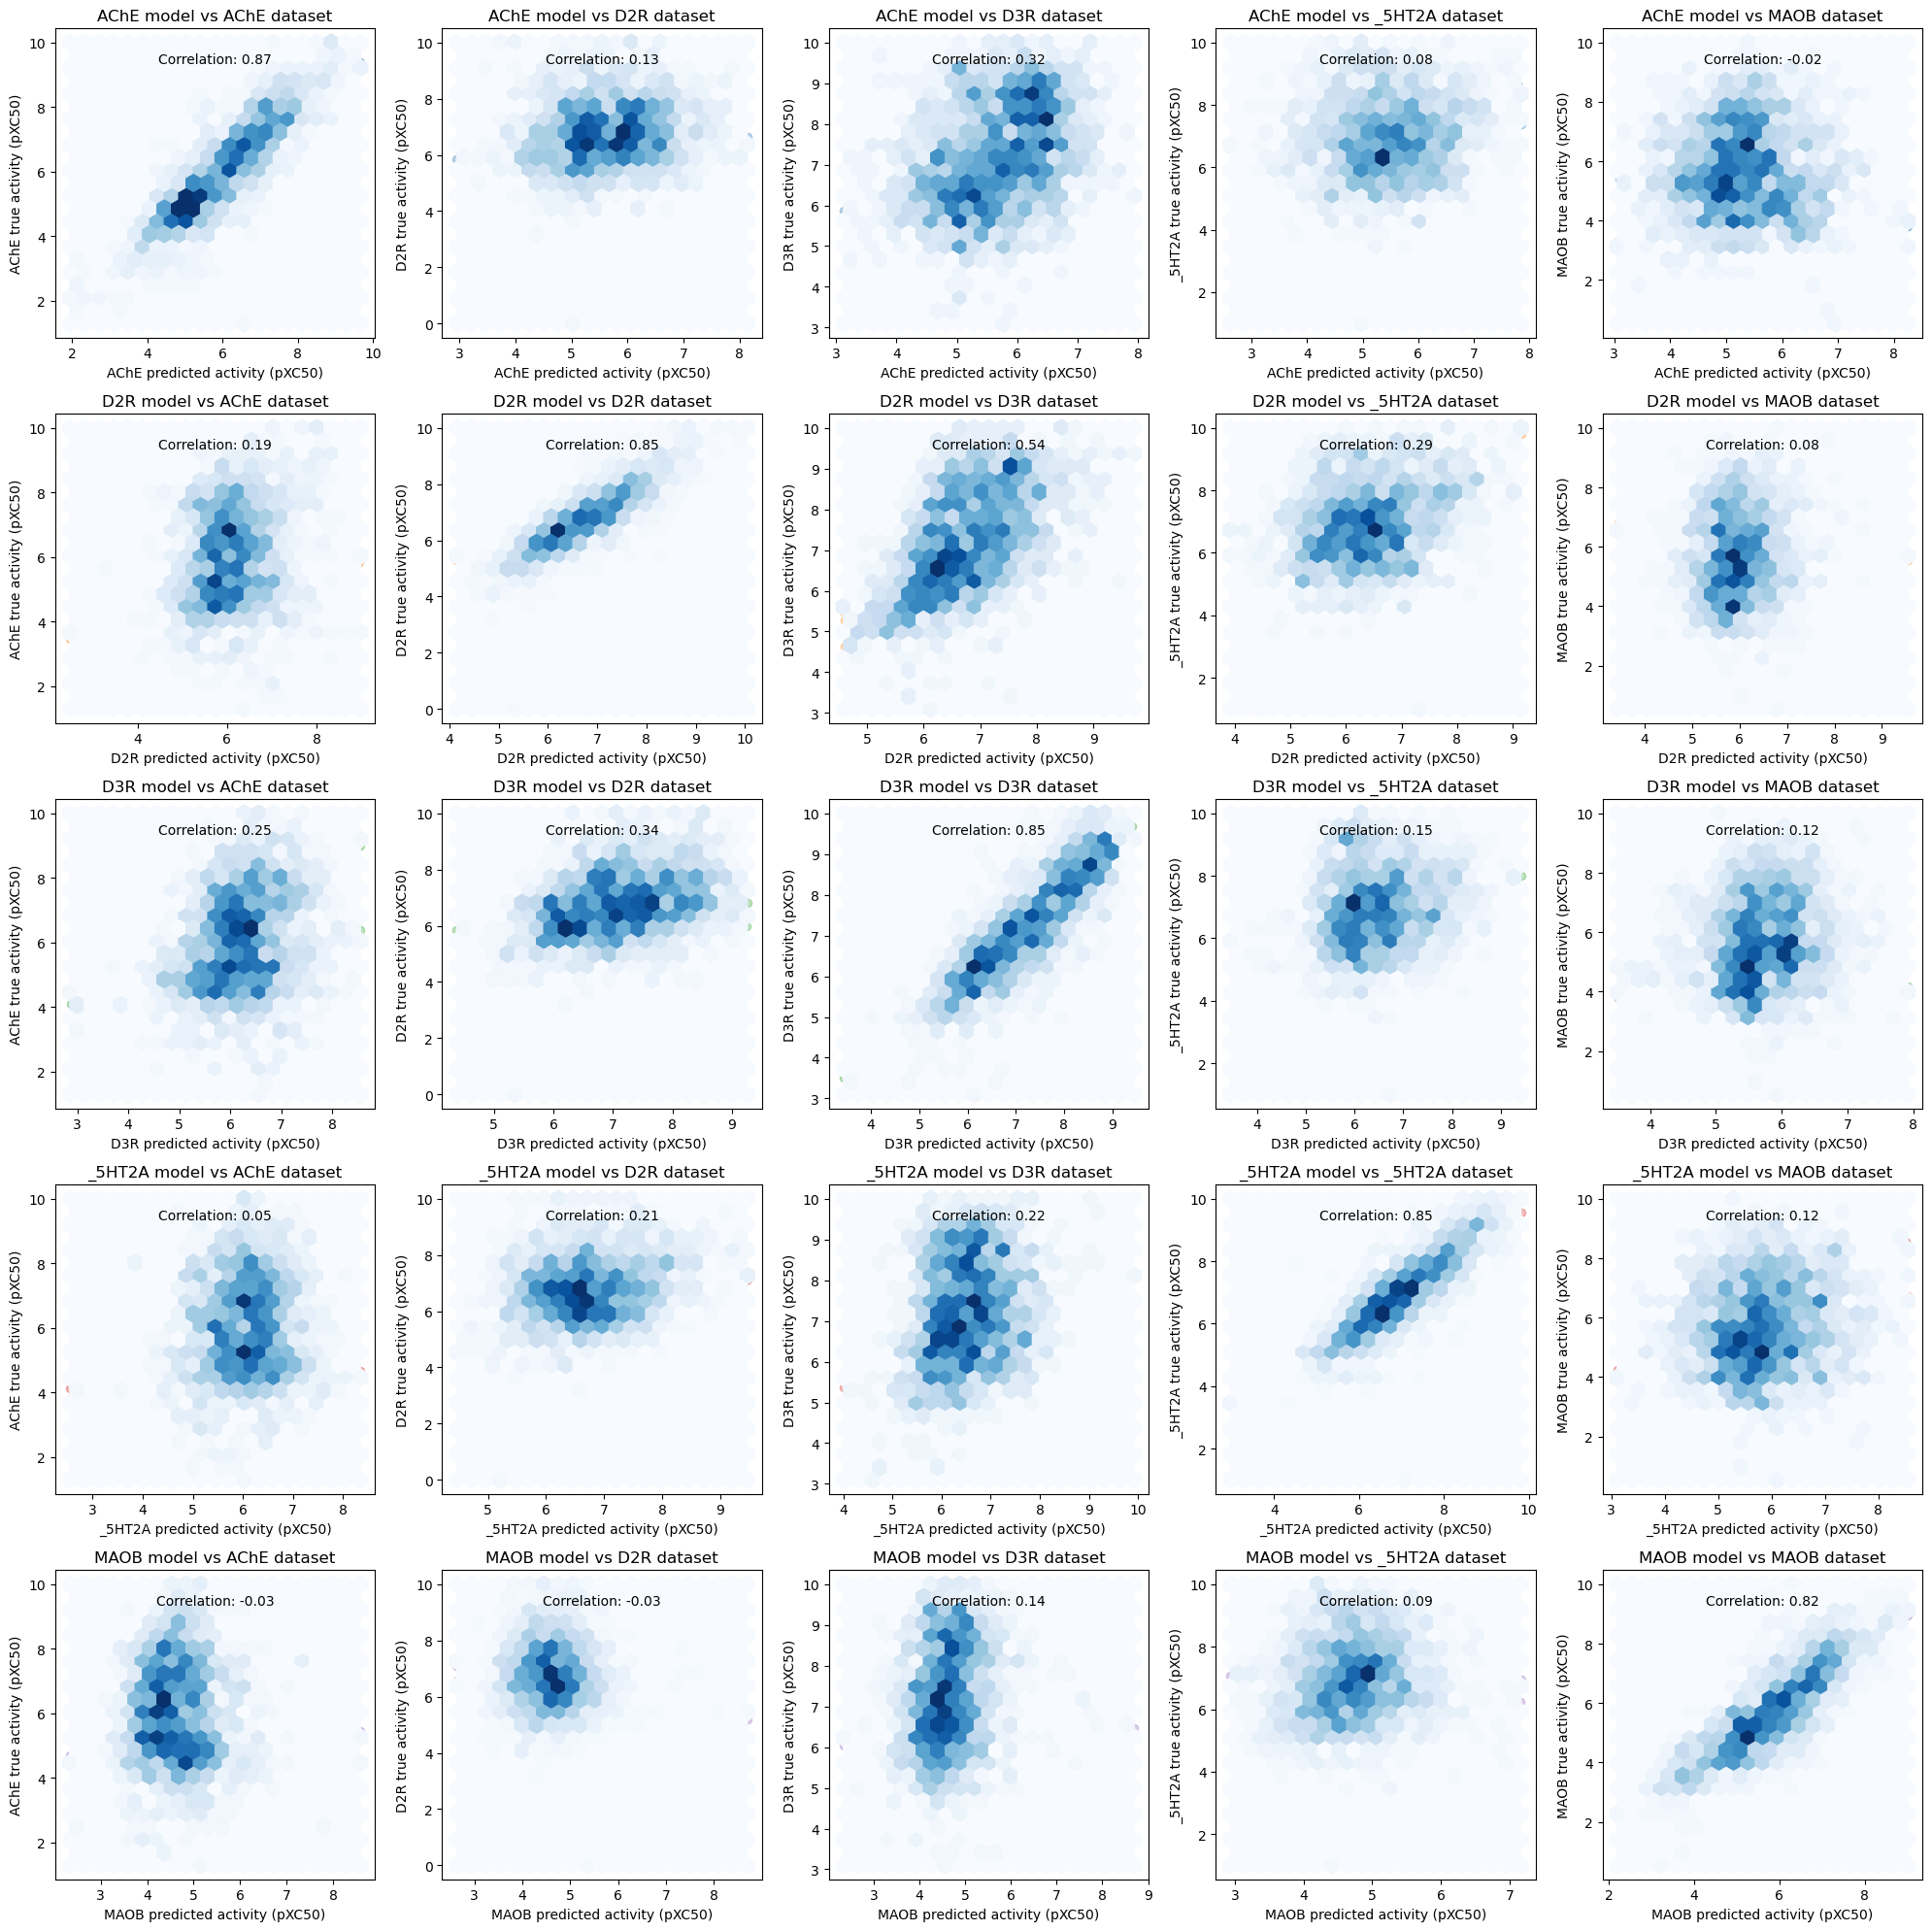

In [26]:
# plot a scatter plot of the predicted activities for each target
# each row is a target model, each column is a target dataset
# the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
fig, axes = plt.subplots(len(targets), len(targets), figsize=(20, 20))

for i, target_model in enumerate(targets):
    for j, target_dataset in enumerate(targets):
        axes[i, j].scatter(
            predicted_activities[target_model][target_dataset], 
            filtered_smiles[target_dataset]['pXC50'],
            alpha=0.3,
            color=pal[i]
        )
        axes[i, j].hexbin(
            predicted_activities[target_model][target_dataset], 
            filtered_smiles[target_dataset]['pXC50'], gridsize=20, cmap='Blues',
        )

        axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
        axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
        axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

        # calculate the correlation coefficient
        correlation = np.corrcoef(
            predicted_activities[target_model][target_dataset], 
            filtered_smiles[target_dataset]['pXC50']
        )[0, 1]

        axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
                        horizontalalignment='center',
                        verticalalignment='center',
                        transform=axes[i, j].transAxes)


plt.tight_layout()
plt.show()